In [1]:
import pandas as pd
import numpy as np 
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.preprocessing import LabelEncoder

In [2]:
X_train_raw = pd.read_parquet("preprocessed/v2/X_train.parquet")
y_train_raw = pd.read_parquet("preprocessed/v2/y_train.parquet")
X_test_raw = pd.read_parquet("preprocessed/v2/X_test.parquet")
y_test_raw = pd.read_parquet("preprocessed/v2/y_test.parquet")

In [3]:
X_train = X_train_raw["text"]
X_test = X_test_raw["text"]

In [4]:
le = LabelEncoder()
le.fit(y_train_raw.values)
le.classes_

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['БАР', 'ОКР', 'ПРЛ', 'депрессия', 'тревожное р-во', 'шизофрения'],
      dtype=object)

In [5]:
y_train = le.transform(y_train_raw.values.ravel())
y_test = le.transform(y_test_raw.values.ravel())

In [6]:
y_test

array([2, 2, 0, ..., 2, 1, 1])

In [7]:
# Загрузка токенизатора и модели
tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-large')
model = BertForSequenceClassification.from_pretrained('sberbank-ai/ruBert-large', num_labels=6)

# Токенизация данных
train_encodings = tokenizer(list(X_train), return_tensors="pt", truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), return_tensors="pt", truncation=True, padding=True, max_length=512)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        #print(item)
        # print(self.labels[idx])
        item['labels'] = torch.LongTensor(np.array([self.labels[idx]])).unsqueeze(0)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train)
test_dataset = Dataset(test_encodings, y_test)

In [9]:
from transformers import TrainerCallback
from sklearn.metrics import f1_score

class ComputeMetricsCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        print(kwargs.keys())
        trainer = kwargs["trainer"]
        eval_dataloader = trainer.get_eval_dataloader()
        output = trainer.prediction_loop(eval_dataloader, description="Evaluation")
        preds = np.argmax(output.predictions, axis=1)
        labels = output.label_ids

        f1_macro = f1_score(labels, preds, average="macro")
        print(f"\nEpoch {state.epoch}: F1-macro: {f1_macro}")
        trainer.log({"f1_macro": f1_macro})

        return control

def compute_metrics(eval_preds):
    preds = np.argmax(eval_preds.predictions, axis=1)
    labels = eval_preds.label_ids.reshape(-1, 1)
    f1_macro = f1_score(labels, preds, average="macro")
    return {"f1_macro": f1_macro}
    

In [10]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [12]:
# Настройка тренера
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    report_to=None,
    gradient_accumulation_steps=4
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    
    # callbacks=[ComputeMetricsCallback()]
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [13]:
# Обучение модели
trainer.train()
# model.save_pretrained("/saved_models", from_pt=True)

/tmp/ipykernel_35940/2715799407.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
0,1.043900,1.044241,0.586154
2,0.458400,0.967148,0.656517
4,0.037900,1.459236,0.673547


/tmp/ipykernel_35940/2715799407.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_35940/2715799407.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/tmp/ipykernel_35940/2715799407.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

TrainOutput(global_step=1220, training_loss=0.5895408858774138, metrics={'train_runtime': 1746.7665, 'train_samples_per_second': 44.757, 'train_steps_per_second': 0.698, 'total_flos': 7.27214509718569e+16, 'train_loss': 0.5895408858774138, 'epoch': 4.99})

In [12]:
# model = BertForSequenceClassification.from_pretrained("results/checkpoint-6000")

In [14]:
from sklearn.metrics import classification_report
import numpy as np

predictions = trainer.predict(test_dataset)

y_pred = np.argmax(predictions.predictions, axis=-1)

y_test_text = le.inverse_transform(y_test)
y_pred_text = le.inverse_transform(y_pred)

metrics = classification_report(y_test_text, y_pred_text, target_names=le.classes_, output_dict=True)

/tmp/ipykernel_35940/2715799407.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [15]:
del metrics["accuracy"]
# print([f"{key}: {type(metrics[key])}" for key, value in metrics.items()])
print([f"{key}: {metrics[key]['f1-score']}" for key, value in metrics.items()])
print("Total: ", metrics["macro avg"]["f1-score"])

['БАР: 0.5729166666666666', 'ОКР: 0.6526655896607432', 'ПРЛ: 0.6488232579603138', 'депрессия: 0.8115384615384615', 'тревожное р-во: 0.7561224489795918', 'шизофрения: 0.5992141453831041', 'macro avg: 0.6735467616981469', 'weighted avg: 0.6862775734761666']
Total:  0.6735467616981469


### Make features

In [16]:
predictions_test = trainer.predict(test_dataset)
predictions_train = trainer.predict(train_dataset)

/tmp/ipykernel_35940/2715799407.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/tmp/ipykernel_35940/2715799407.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [17]:
train_scores_df = pd.DataFrame(predictions_train.predictions, columns=le.classes_)
test_scores_df = pd.DataFrame(predictions_test.predictions, columns=le.classes_)

In [18]:
def make_topic_label_feature(features):
    url_to_label = features.groupby(["url"])["bert_label"].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
    url_to_label_dict = dict(zip(url_to_label["url"], url_to_label["bert_label"]))
    features["label_each_url"] = features["url"].map(url_to_label_dict)
    features = features.drop("bert_label", axis=1)
    return features

In [19]:
train_bert_labels = pd.Series(np.argmax(predictions_train.predictions, axis=-1), name="bert_label")
train_features = pd.concat([X_train_raw["url"], train_bert_labels], axis=1)
train_features = make_topic_label_feature(train_features)


test_bert_labels = pd.Series(np.argmax(predictions_test.predictions, axis=-1), name="bert_label")
test_features = pd.concat([X_test_raw["url"], test_bert_labels], axis=1)
test_features = make_topic_label_feature(test_features)


In [20]:
cb_X_train = pd.concat([train_features, train_scores_df], axis=1)
cb_X_test = pd.concat([test_features, test_scores_df], axis=1)

In [21]:
X_train_raw["url"].nunique()

2222

In [22]:
cb_X_train.columns

Index(['url', 'label_each_url', 'БАР', 'ОКР', 'ПРЛ', 'депрессия',
       'тревожное р-во', 'шизофрения'],
      dtype='object')

In [23]:
categorical_features = ["url", "label_each_url"]

In [28]:
from catboost import CatBoostClassifier, Pool

cb_model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.05,
    depth=6,
    eval_metric="TotalF1",
    # early_stopping_rounds=400,
    # l2_leaf_reg=8,
    # loss_function="Logloss",
    # eval_metric="AUC",
    # eval_metric = avgAUC(valid_features['impression_id'], metric_period=METRIC_PERIOD),
    # gpu_ram_part=0.65,
    task_type="GPU",
    # devices="0:1:2:3",
    auto_class_weights="Balanced",

)

cb_model.fit(cb_X_train, y_train, eval_set=(cb_X_test, y_test), verbose=1, cat_features=categorical_features, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9949885	test: 0.6612688	best: 0.6612688 (0)	total: 93ms	remaining: 4m 38s
1:	learn: 0.9948215	test: 0.6602963	best: 0.6612688 (0)	total: 196ms	remaining: 4m 54s
2:	learn: 0.9948215	test: 0.6602963	best: 0.6612688 (0)	total: 297ms	remaining: 4m 56s
3:	learn: 0.9949329	test: 0.6608653	best: 0.6612688 (0)	total: 396ms	remaining: 4m 56s
4:	learn: 0.9949329	test: 0.6617359	best: 0.6617359 (4)	total: 582ms	remaining: 5m 48s
5:	learn: 0.9943982	test: 0.6592013	best: 0.6617359 (4)	total: 682ms	remaining: 5m 40s
6:	learn: 0.9942862	test: 0.6565379	best: 0.6617359 (4)	total: 697ms	remaining: 4m 58s
7:	learn: 0.9953749	test: 0.6599979	best: 0.6617359 (4)	total: 888ms	remaining: 5m 32s
8:	learn: 0.9953191	test: 0.6623467	best: 0.6623467 (8)	total: 984ms	remaining: 5m 26s
9:	learn: 0.9955979	test: 0.6784300	best: 0.6784300 (9)	total: 1.09s	remaining: 5m 26s
10:	learn: 0.9956532	test: 0.6787712	best: 0.6787712 (10)	total: 1.28s	remaining: 5m 48s
11:	learn: 0.9960409	test: 0.6863781	best:

In [29]:
cb_preds = le.inverse_transform(cb_model.predict(cb_X_test))
metrics_cb = classification_report(y_test_text, cb_preds, target_names=le.classes_, output_dict=True)
del metrics_cb["accuracy"]
print([f"{key}: {metrics_cb[key]['f1-score']}" for key, value in metrics_cb.items()])
print("Total: ", metrics_cb["macro avg"]["f1-score"])

['БАР: 0.6881077038145101', 'ОКР: 0.7622993267736924', 'ПРЛ: 0.7218390804597701', 'депрессия: 0.8500727802037845', 'тревожное р-во: 0.8187919463087249', 'шизофрения: 0.6598984771573604', 'macro avg: 0.7501682191196405', 'weighted avg: 0.7620906899987903']
Total:  0.7501682191196405


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


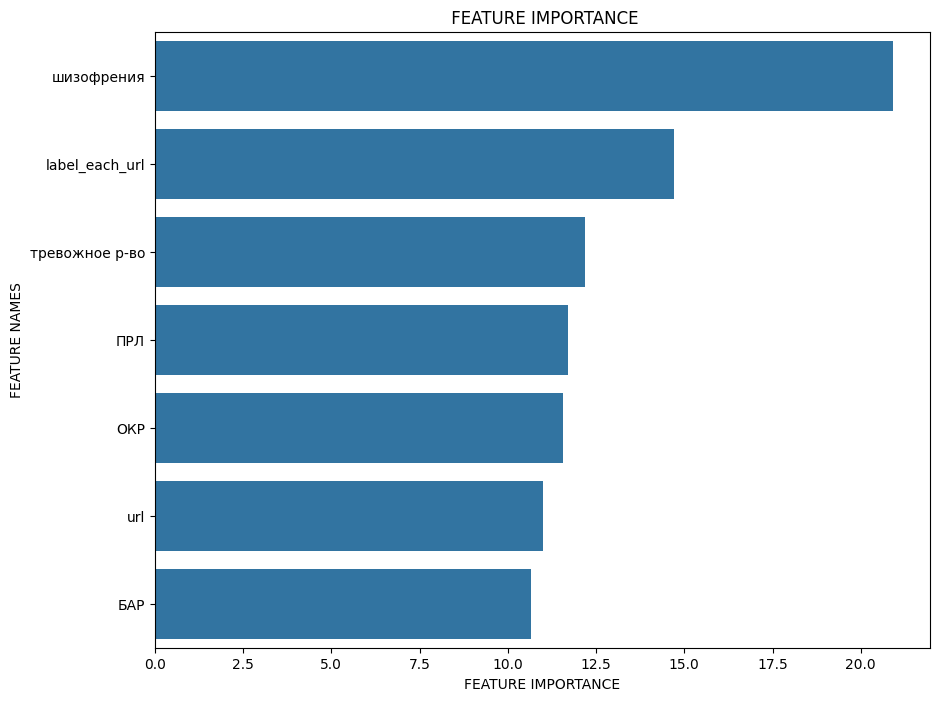

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """
        Функция вывода feature importance
            :importance - массив важности фичей, полученный от модели
            :names - массив названий фичей
            :model_name - название модели
            :top_n - кол-во выводимых фичей
            :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                            из отображаемых горячие фичи, и изучить менее сильные
            :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {"feature_names": feature_names, "feature_importance": feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel("FEATURE IMPORTANCE")
    plt.ylabel("FEATURE NAMES")
    return fi_df

features_list = ['url', 'label_each_url', 'БАР', 'ОКР', 'ПРЛ', 'депрессия',
       'тревожное р-во', 'шизофрения']
dfi = plot_feature_importance(cb_model.get_feature_importance(), features_list)